# Предсказание температуры стали в процессе легирования

Наш заказчик, металлургический комбинат, просит нас построить модель для предсказания температуры стали при её легировании.

В нашем распоряжении различные физические характеристики ковша, в котором происходит легирование и данные о добавленных присыпках, проволоке и газе.

---

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [1]:
!pip install phik -q
!pip install shap -q

# Импортируем основные библиотеки для работы
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import functools as ft
import phik
import shap
import os

# Импортируем модели, метрики, вспомогательные инструменты и функции
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

random_state = 190623

n_cpus = os.cpu_count()
n_jobs = n_cpus - 2

## Подготовка данных

### Загрузка датасетов

Откроем файлы и сохраним их в переменных df_\*.

In [2]:
try:
    df_arc = pd.read_csv('data_arc_new.csv')
    df_bulk = pd.read_csv('data_bulk_new.csv')
    df_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    df_gas = pd.read_csv('data_gas_new.csv')
    df_temp = pd.read_csv('data_temp_new.csv')
    df_wire = pd.read_csv('data_wire_new.csv')
    df_wire_time = pd.read_csv('data_wire_time_new.csv')
except:
    df_arc = pd.read_csv('/datasets/data_arc_new.csv')
    df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    df_gas = pd.read_csv('/datasets/data_gas_new.csv')
    df_temp = pd.read_csv('/datasets/data_temp_new.csv')
    df_wire = pd.read_csv('/datasets/data_wire_new.csv')
    df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

### Изучение основной информации о датасетах

Взглянем на первые строки данных наших датасетов, чтобы иметь представление с чем мы имеем дело.

In [3]:
df_arc.head(15)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [4]:
df_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [5]:
df_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [6]:
df_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [7]:
df_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [8]:
df_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получим информацию с помощью `.info()`:

In [10]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [11]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [12]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [13]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [14]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [15]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [16]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Оценим, сколько у нас пропусков целевого признака:

In [17]:
df_temp[df_temp['Температура'].isnull()].head(10)

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN
13936,2501,2019-08-10 15:22:50,NaN
13937,2501,2019-08-10 15:29:00,NaN


In [18]:
df_temp[df_temp['Температура'].isnull()].tail(10)

,key,Время замера,Температура
18081,3240,2019-09-06 15:30:52,NaN
18082,3240,2019-09-06 15:58:35,NaN
18083,3240,2019-09-06 16:02:31,NaN
18084,3240,2019-09-06 16:21:44,NaN
18085,3240,2019-09-06 16:35:26,NaN
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


In [19]:
df_temp.count() / df_temp.shape[0]

key             1.000000
Время замера    1.000000
Температура     0.810579
dtype: float64

Посмотрим на основные статистики датасетов:

In [20]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Похоже на аномалию в "реактивной мощности":

In [21]:
df_arc[df_arc['Реактивная мощность'] < 0].head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [22]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [23]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [24]:
df_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [25]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Построим гистограммы для всех датасетов:

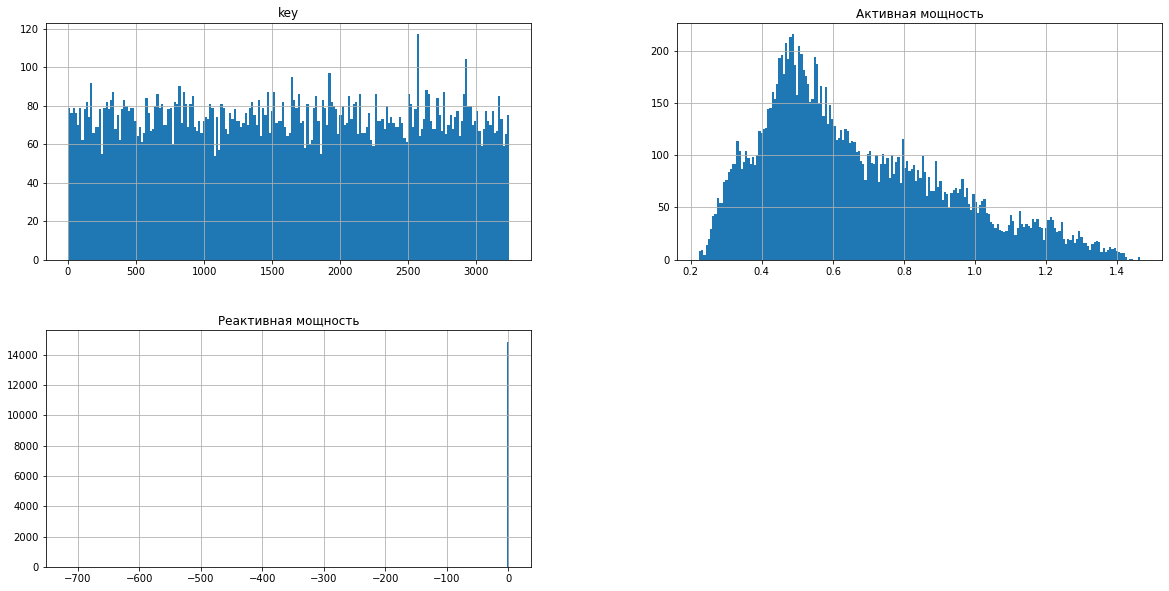

In [26]:
df_arc.hist(figsize=(20, 10), bins=200)
plt.show()

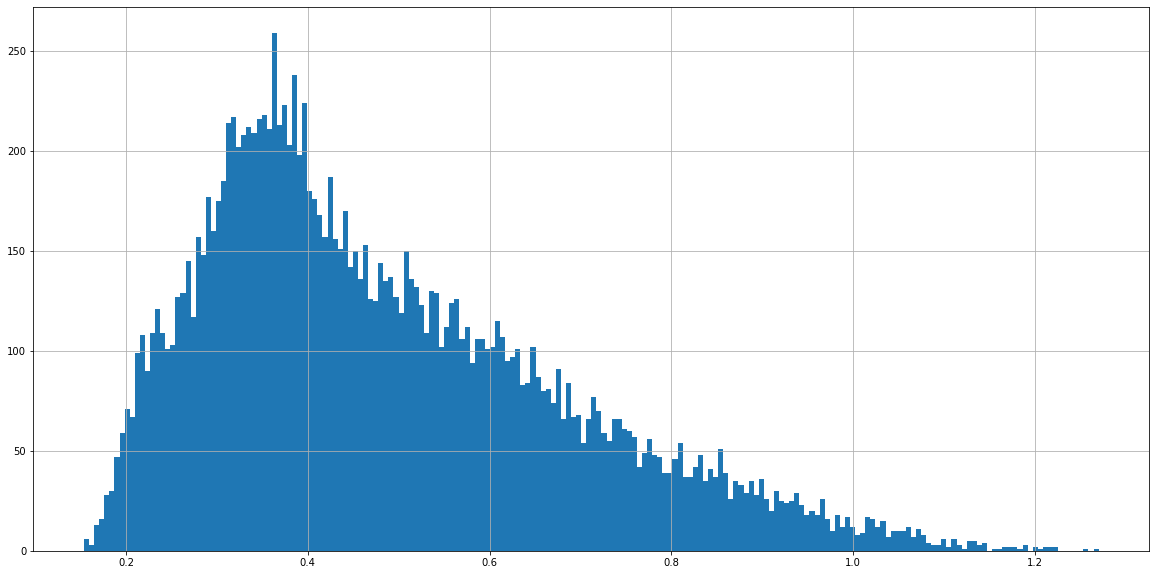

In [27]:
df_arc[df_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(figsize=(20, 10), bins=200)
plt.show()

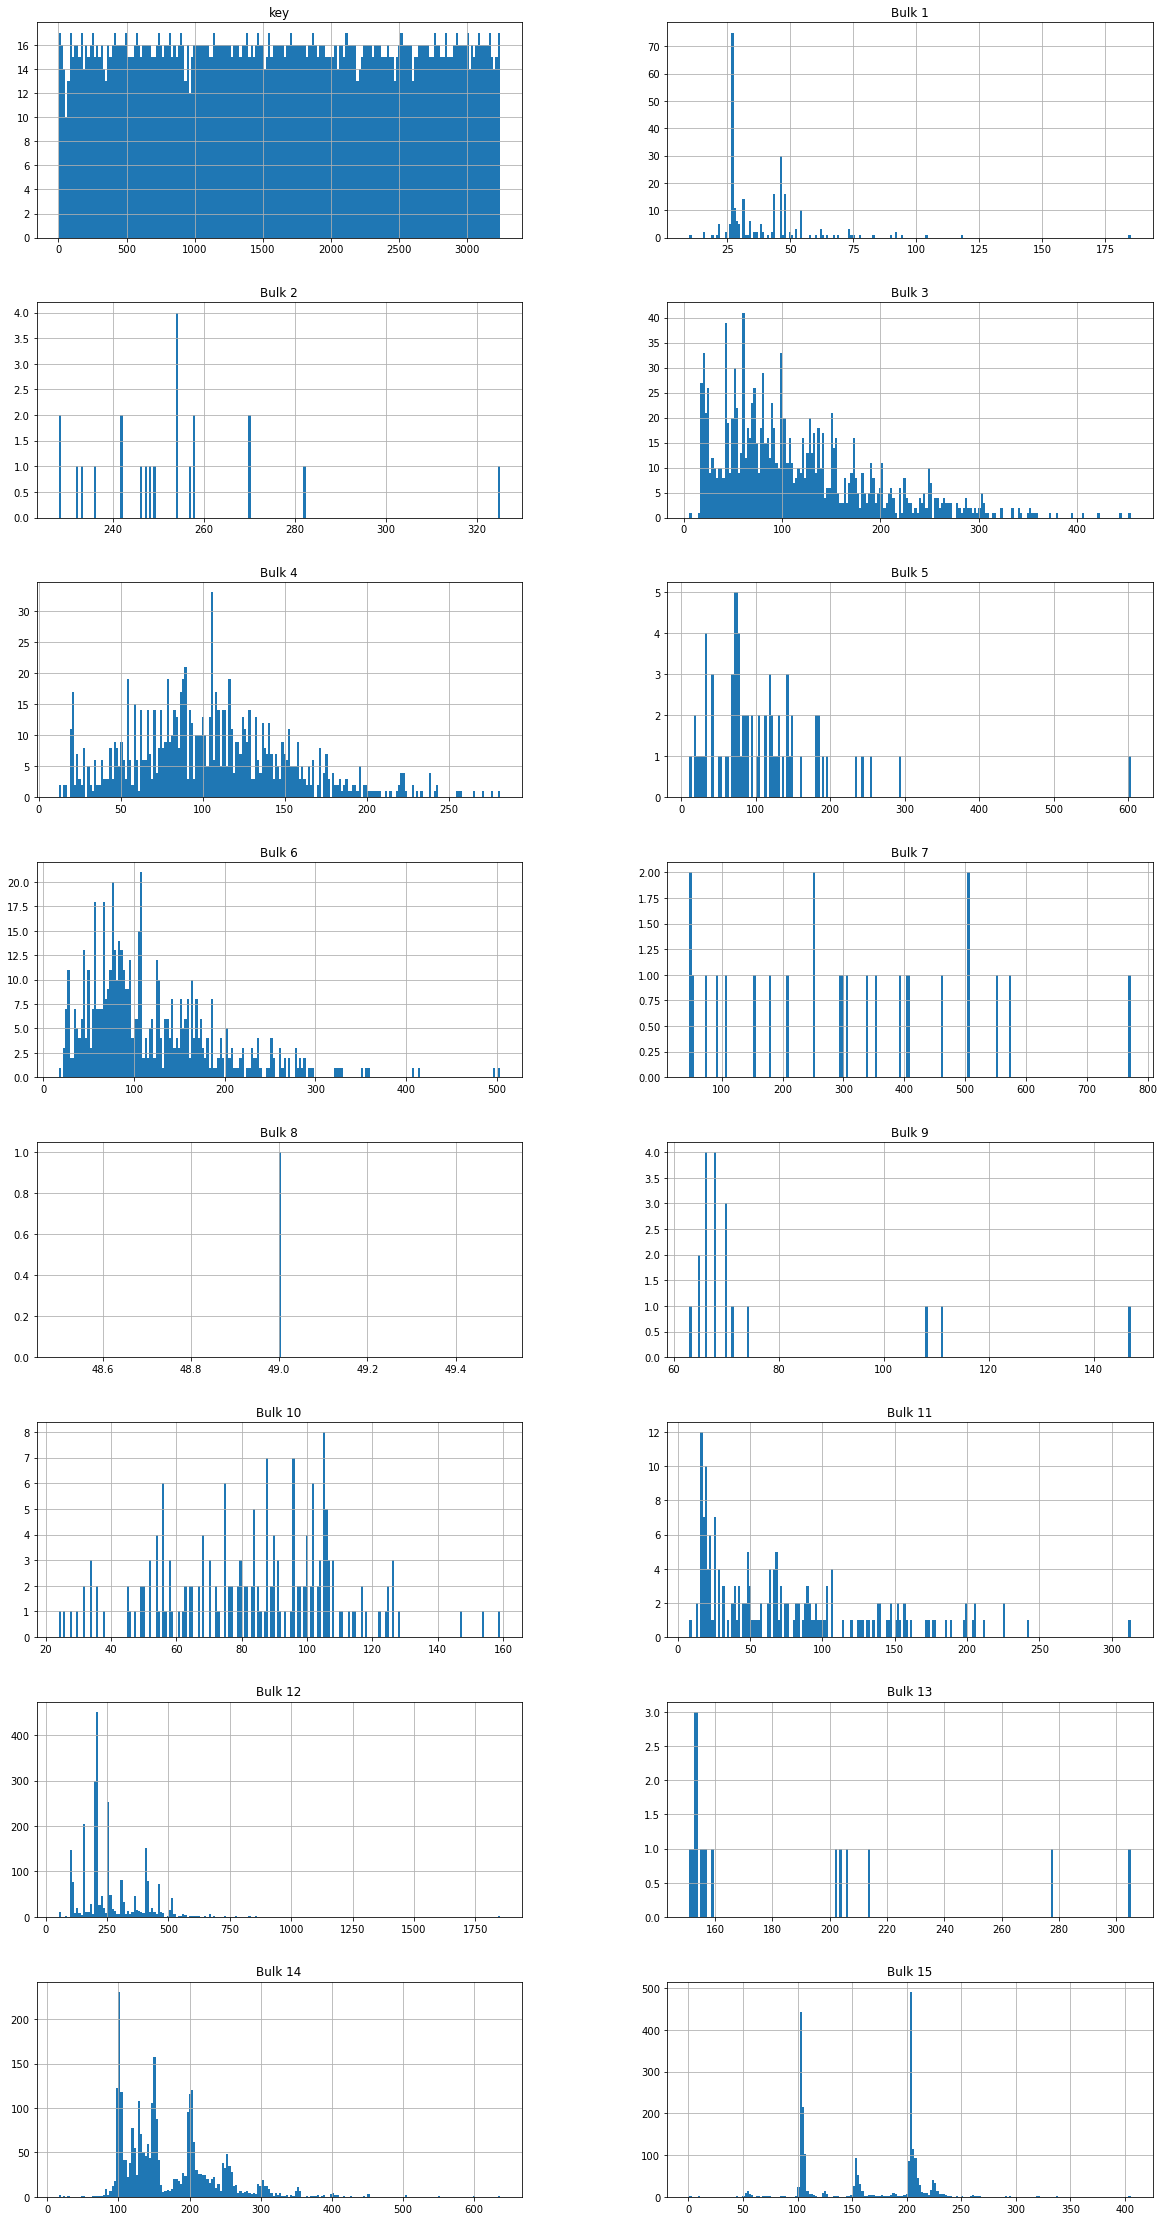

In [28]:
df_bulk.hist(figsize=(20, 40), bins=200, layout=(8,2))
plt.show()

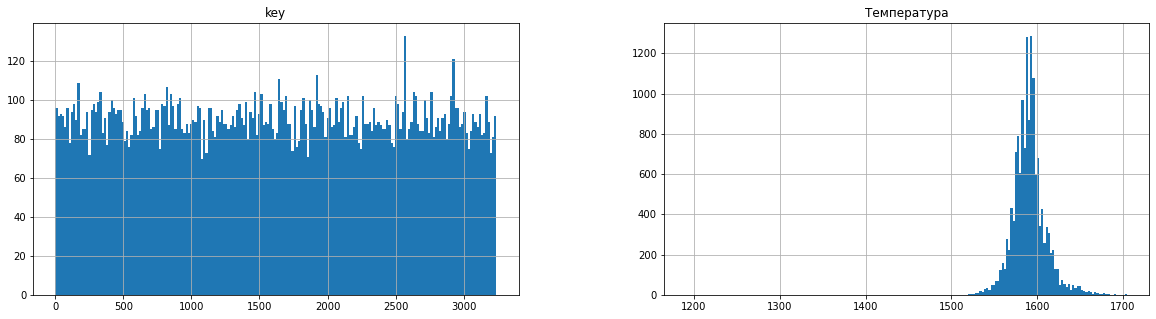

In [29]:
df_temp.hist(figsize=(20, 5), bins=200)
plt.show()

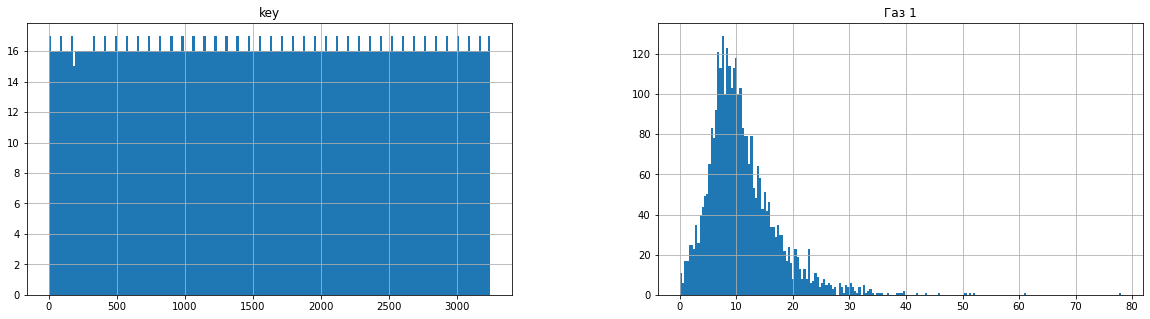

In [30]:
df_gas.hist(figsize=(20, 5), bins=200)
plt.show()

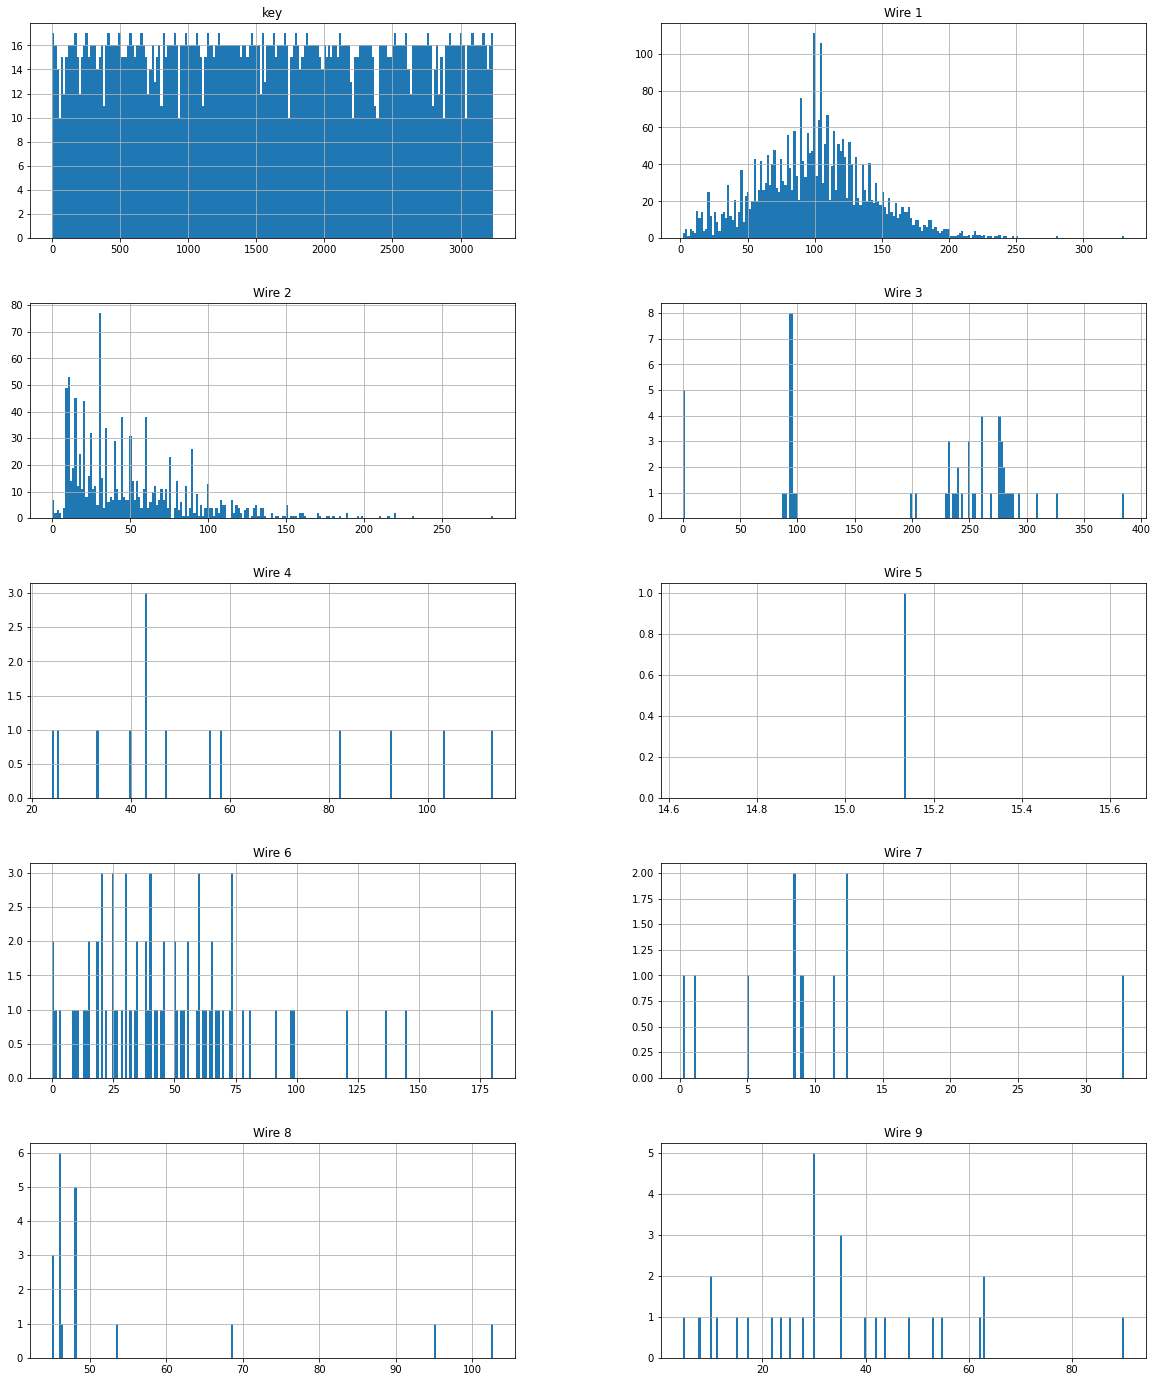

In [31]:
df_wire.hist(figsize=(20, 40), bins=200, layout=(8,2))
plt.show()

---
**Выводы**: завершив этап подготовки данных, мы обнаружили, что
- данные в датасете df_arc представляют собой итерации прогревов металла графитовыми электродами; каждая строка - итерация прогрева;
    - пропусков в df_arc нет;
    - присутствует аномалия - "Реактивная мощность" со значением -715.48;
- данные в датасетах df_bulk и df_wire представляют собой строки, в которых собрана сразу вся информация по всем итерациям - в разных признаках, а датасеты \*\_time - временные метки для каждой итерации добавления сыпучих материалов/проволоки;
    - данные разрежены в данных датасетах; есть признаки с высокой плотностью значений, а остальные - по большей части пустые; это соответствует тому, что при легировании каждой новой партии, было осуществлено всего 2-3 итерации добавления сыпучих материалов/проволоки и только в редких случаях - больше 4-5; 
- данные в датасете df_gas представляют собой одиночные строки добавления газа в партии металла; неитеративные;
    - строк в датасете практически столько же, сколько всего партий - 3239 строк на 3241 партии;
- данные в датасете df_temp представляют собой итерации замеров температуры после процесса легирования стали - включая замер температуры до начала процесса;
    - в данных присутствуют пропуски - около 19% строк с пропусками значений температуры;
    - у температуры большая часть распределения находится в диапазоне 1500-1700 градусов; есть значения с температурой около 1200 градусов, судя по всему, выброс;


- судя по временным меткам, итеративный процесс легирования стали можно выразить в виде цепочки:(если это 1ая итерация — замер температуры -> ) старт нагрева электродов -> финиш нагрева электродов -> добавление проволоки/сыпучих материалов → добавление газа -> замер температуры ( -> новая итерация).



### Вопросы к заказчику

1. Можем ли мы отбросить строки с пропуском температуры? Таких строк 19% от датасета data_temp. И это целевой признак.
2. В датасете data_arc в признаке «Реактивная мощность» есть аномалия — значение -715.48. Прошу бизнес подтвердить факт аномалии.
3. В датасете data_bulk есть признаки Bulk 1...15 — это разные сыпучие материалы или один и тот же, но на разных итерациях?
4. Аналогичный вопрос касательно датасета data_wire и признаков wire 1...9.
5. Судя по временным меткам, итерация легирования стали выглядит так: (если это 1ая итерация — замер температуры -> ) старт нагрева электродов -> финиш нагрева электродов -> добавление проволоки/сыпучих материалов → добавление газа -> замер температуры ( -> новая итерация). Мы верно понимаем итеративный процесс?
6. Как соединить таблицы в одну? Если нам нужно смоделировать итеративный процесс и Bulk 1...15 — это один и тот же сыпучий материал, а Wire 1...9 — одна и та же проволока, то верно будет сформировать финальную таблицу на основе таблицы data_arc, добавив в неё новые признаки: 1) температура на момент начала итерации, 2) температура в конце итерации (целевой признак!), 3) объём добавленных сыпучих материалов, 4) объём добавленной проволоки, 5) объём добавленного газа. Присоединять указанные признаки необходимо будет по ключу номера партии и временным меткам — время добавления сыпучих материалов/проволоки и замер температуры должны укладываться в промежуток от метки финиша прогрева электродов до начала прогрева электродов следующей итерации (следующей строки таблицы).
7. Для признаков Bulk 1...15 датасета data_bulk — что считать выбросами, а что экстремальными значениями, если у нас есть диапазон значений от 1 до 1849.
8. Для признака Gas 1 датасета data_gas — что считать выбросами, а что экстремальными значениями, если у нас есть диапазон значений от 0.01 до 77.99.
9. Для признаков Wire 1...9 датасета data_wire - что считать выбросами, а что экстремальными значениями, если у нас есть диапазон значений от 0.03 до 385.01.
10. Предполагается ли сильная экстраполяция будущих данных? Этот вопрос влияет на выбор предпочтительной модели МО — если предполагается сильная экстраполяция, то необходим выбор в пользу линейной регрессии, если нет — градиентный бустинг.
11. Какую метрику предпочтительней использовать? MAE, RMSE, sMAPE?

### Дальнейший план работ по проекту

Дальнейший план можно охарактеризовать следующим образом:

    1) Предобработка данных:
        1.1) Соединение датасетов в одну таблицу;
        1.2) Устранение аномалий и выбросов;
        1.3) Проверка на дубликаты;
        1.4) Проверка на мультиколлинеарность и анализ корреляций с помощью коэффициентов корреляции Пирсона и Phik (𝜙k);
        1.5) Выводы по этапу;
        
        
    2) Построение моделей:
        2.1) Подготовка наборов данных для обучения и тестирования (будем использовать кросс-валидацию, поэтому обучающая выборка будет сразу включать валидационную);
        2.2) Подготовка preprocessing-шага для pipeline'ов, которая будет включать в себя заполнение пропусков в данных и стандартизацию;
        2.3) Выбор метрики;
        2.4) Построение моделей линейной регрессии с регуляризацией и градиентного бустинга - с использованием GridSearchCV;
        2.5) Выводы по этапу;
        
        
    3) Анализ моделей:
        3.1) Выбор лучшей модели на основе метрик;
        3.2) Тестирование лучшей модели;
        3.3) Анализ разниц между целевым признаком и предсказанием и между ошибкой и целевым признаком - с помощью графиков рассеяния;
        3.4) Анализ важности факторов у лучшей модели;
        3.5) Проверка моделей на адекватность;
        3.6) Выводы по этапу;
        
        
    4) Общие выводы.

## Предобработка данных

### Соединение датасетов в одну таблицу

Чтобы смоделировать процесс легирования стали, нам необходимо соединить наши датасеты в одну таблицу. Объектом моделирования будет ковш, в котором происходит легирование партии стали.

Сперва обработаем датасет с данными по накаливанию дуги. Агрегируем данные в нём, чтобы получить итоговые затраты энергии по каждой партии.

In [32]:
df_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [33]:
df_arc = df_arc.rename(columns={
    'Начало нагрева дугой' : 'start_time',
    'Конец нагрева дугой' : 'end_time',
    'Активная мощность' : 'active_power',
    'Реактивная мощность' : 'reactive_power'})

In [34]:
df_arc.head(10)

,key,start_time,end_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Рассчитаем время накаливания дуги для каждой итерации. Сохраним в новой переменной:

In [35]:
df_arc['start_time'] = pd.to_datetime(df_arc['start_time'], format='%Y-%m-%d %H:%M:%S')
df_arc['end_time'] = pd.to_datetime(df_arc['end_time'], format='%Y-%m-%d %H:%M:%S')

In [36]:
df_arc['heating_time'] = (df_arc['end_time'] - df_arc['start_time']).dt.seconds

Рассчитаем полную мощность. Она рассчитывается как корень из суммы квадратов активной и реактивной мощностей:

In [37]:
df_arc['full_power'] = np.sqrt(df_arc['active_power'] ** 2 + df_arc['reactive_power'] ** 2)

Теперь посчитаем затраченную энергию, умножив полную мощность на время накаливания дуги:

In [38]:
df_arc['spent_energy'] = df_arc['full_power'] * df_arc['heating_time']

In [39]:
df_arc.head(10)

,key,start_time,end_time,active_power,reactive_power,heating_time,full_power,spent_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934,159.830252
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137,0.440239,60.312695
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338,0.332731,112.463079
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126,0.860064,108.368056
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210,0.955315,200.616176
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280,1.373863,384.681584


Агрегируем затраченную энергию для каждой партии стали:

In [40]:
df_arc_agg = df_arc.groupby(['key'], as_index=False).agg({'spent_energy' : 'sum'})

In [41]:
df_arc_agg.head(10)

,key,spent_energy
0,1,770.282114
1,2,481.760005
2,3,722.837668
3,4,683.455597
4,5,512.169934
5,6,839.231310
6,7,613.576982
7,8,619.129542
8,9,570.113675
9,10,533.482050


С предварительной обработкой датасета накаливания дуг мы закончили.

---

Теперь обработаем датасет с замерами температуры. Нам нужно сохранить в одной строке начальную температуру до легирования и финальную - после всех итераций.

In [42]:
df_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [43]:
df_temp = df_temp.rename(columns={'Время замера' : 'event_time', 'Температура' : 'temperature'})

Сгруппируем отсортированные значения температуры:

In [44]:
df_temp_grouped = df_temp.sort_values(by='event_time').groupby(['key'])

Соединим в одну таблицу первую и последнюю запись сгруппированной таблицы:

In [45]:
df_temp_agg = pd.merge(df_temp_grouped.head(1), df_temp_grouped.tail(1), how='left', on='key')

In [46]:
df_temp_agg.head()

,key,event_time_x,temperature_x,event_time_y,temperature_y
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


Проверим, что у нас нет записей, у которых был только один единственный замер температуры и избавимся от них:

In [47]:
df_temp_agg[df_temp_agg['event_time_x'] == df_temp_agg['event_time_y']].head(10)

,key,event_time_x,temperature_x,event_time_y,temperature_y
192,195,2019-05-11 00:01:36,1583.0,2019-05-11 00:01:36,1583.0
276,279,2019-05-14 10:13:01,1603.0,2019-05-14 10:13:01,1603.0


In [48]:
df_temp_agg = df_temp_agg[df_temp_agg['event_time_x'] != df_temp_agg['event_time_y']]

In [49]:
df_temp_agg = df_temp_agg.rename(columns={'temperature_x' : 'start_temp', 'temperature_y' : 'end_temp'})

С предварительной обработкой таблицы замеров температуры мы закончили.

---

Переименуем признаки в датасете df_bulk:

In [50]:
df_bulk.columns = df_bulk.columns.str.lower().str.replace(' ', '_')

In [51]:
df_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


---

Переименуем признаки в датасете df_wire:

In [52]:
df_wire.columns = df_wire.columns.str.lower().str.replace(' ', '_')

In [53]:
df_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

Переименуем признаки в датасете df_gas:

In [54]:
df_gas = df_gas.rename(columns={'Газ 1' : 'gas'})

---

Пришло время соединить обработанные нами таблицы в одну - по номеру партии.

In [55]:
data_frames = [df_arc_agg, df_temp_agg, df_bulk, df_wire, df_gas]

In [56]:
df_full = ft.reduce(lambda left, right: pd.merge(left, right, on=['key'],
                                            how='left'), data_frames)

In [57]:
df_full.head()

,key,spent_energy,event_time_x,start_temp,event_time_y,end_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas
0,1,770.282114,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986
1,2,481.760005,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561
2,3,722.837668,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793
3,4,683.455597,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219
4,5,512.169934,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692


Избавимся от строк, в которых все признаки сыпучих материалов пусты и все значения проволоки пусты - значит, этих строк не было в соответствующих датасетах. Также избавимся от строк, в которых неизвестна начальная или финальная (целевая) температура и в которых значение газа пусто.

In [58]:
bulk_columns = ['bulk_' + str(x) for x in range(1, 16, 1)]
wire_columns = ['wire_' + str(x) for x in range(1, 10, 1)]

In [59]:
df_full = df_full.dropna(subset=bulk_columns, how='all')
df_full = df_full.dropna(subset=wire_columns, how='all')
df_full = df_full.dropna(subset=['start_temp', 'end_temp'])
df_full = df_full.dropna(subset=['gas'])

---

Снова взглянем на основную информацию нашего полного датасета:

In [60]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2329 non-null   int64  
 1   spent_energy  2329 non-null   float64
 2   event_time_x  2329 non-null   object 
 3   start_temp    2329 non-null   float64
 4   event_time_y  2329 non-null   object 
 5   end_temp      2329 non-null   float64
 6   bulk_1        199 non-null    float64
 7   bulk_2        13 non-null     float64
 8   bulk_3        960 non-null    float64
 9   bulk_4        812 non-null    float64
 10  bulk_5        53 non-null     float64
 11  bulk_6        438 non-null    float64
 12  bulk_7        13 non-null     float64
 13  bulk_8        1 non-null      float64
 14  bulk_9        13 non-null     float64
 15  bulk_10       143 non-null    float64
 16  bulk_11       130 non-null    float64
 17  bulk_12       1812 non-null   float64
 18  bulk_13       14 non-null   

In [61]:
df_full.describe()

,key,spent_energy,start_temp,end_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas
count,2329.000000,2329.000000,2329.000000,2329.000000,199.000000,13.000000,960.000000,812.000000,53.000000,438.000000,13.000000,1.0,13.000000,143.000000,130.000000,1812.000000,14.000000,2068.000000,1699.000000,2306.000000,811.000000,39.000000,12.000000,0.0,45.000000,4.000000,13.000000,24.000000,2329.000000
mean,1251.832546,703.226851,1586.718763,1593.365393,40.115578,254.846154,114.868750,106.995074,116.018868,119.269406,359.153846,49.0,79.692308,82.293706,76.053846,267.880795,177.571429,173.271277,164.432019,103.465371,50.571346,193.182538,59.496235,NaN,50.659374,3.703414,55.772561,30.773167,11.375600
std,714.762400,1639.145999,28.290792,11.200915,18.226180,25.973853,77.485694,49.050943,95.189182,70.747953,208.804472,NaN,25.795299,27.788900,60.373554,125.588642,50.344527,64.009860,50.039060,42.530971,39.755956,100.867783,30.804638,NaN,37.743040,3.818433,20.235591,15.210141,6.392041
min,1.000000,33.430208,1191.000000,1541.000000,10.000000,228.000000,6.000000,13.000000,11.000000,17.000000,75.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,29.000000,1.000000,1.918800,0.030160,0.144144,24.148801,NaN,0.137280,0.234208,45.076721,4.622800,0.008399
25%,630.000000,457.872635,1571.000000,1587.000000,27.000000,242.000000,57.000000,73.000000,70.000000,72.000000,178.000000,49.0,66.000000,58.000000,25.000000,204.000000,153.250000,123.000000,105.000000,75.042236,20.193680,93.189102,38.347402,NaN,25.053600,0.849004,46.002319,20.802601,7.282948
50%,1255.000000,630.913482,1587.000000,1593.000000,33.000000,248.000000,96.500000,105.000000,88.000000,100.000000,392.000000,49.0,68.000000,85.000000,60.000000,208.000000,154.500000,153.000000,200.000000,102.053638,40.112801,236.972740,49.661561,NaN,40.085762,3.044704,46.187439,30.066399,10.100950
75%,1868.000000,841.644330,1603.000000,1598.000000,46.500000,258.000000,152.250000,136.250000,148.000000,155.750000,507.000000,49.0,71.000000,104.000000,105.500000,359.250000,158.500000,208.000000,205.000000,128.220310,69.699761,277.068801,84.755579,NaN,65.036400,5.899114,46.279999,40.495001,14.216688
max,2499.000000,78258.076839,1660.000000,1653.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,330.314424,282.780152,385.008668,113.231044,NaN,180.454575,8.490040,102.762401,62.025600,77.995040


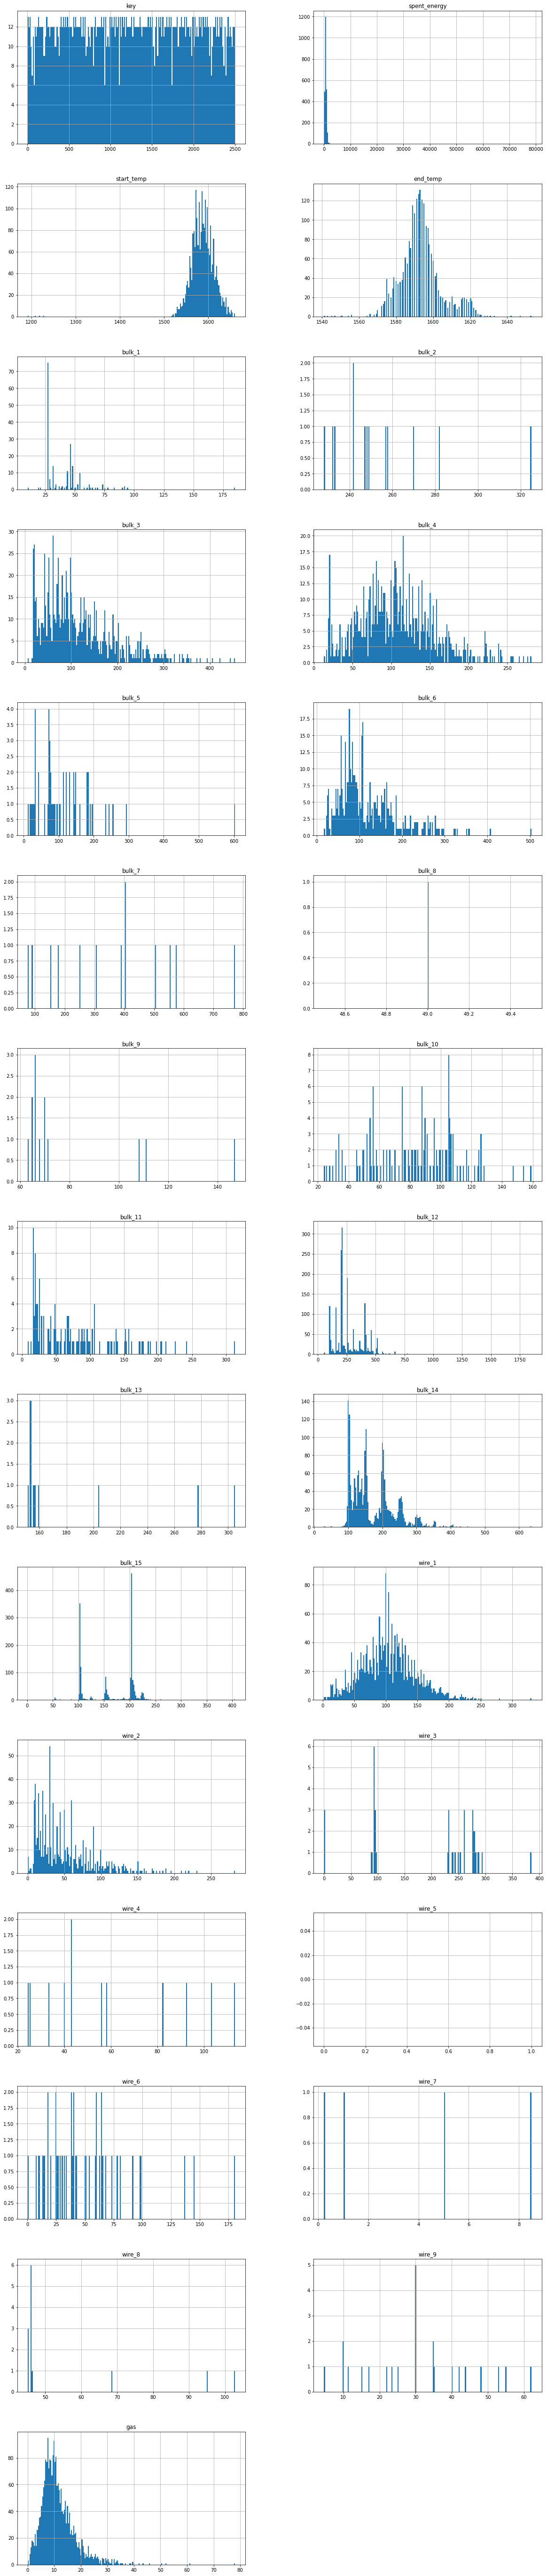

In [62]:
df_full.hist(figsize=(20, 100), bins=200, layout=(15,2))
plt.show()

Как мы видим, у нас присутствуют аномальные значения в затраченной энергии и в начальной температуре. Будем устранять их в следующей главе.

### Устранение аномалий и выбросов

Как мы подметили выше, у нас есть аномалии в затраченной энергии - значение около 72000. Кроме того, в партиях присутствуют строки с начальной температурой около 1200 градусов, что не соответствует температуре плавления стали (1350 градусов) и может указывать на другой металл. От таких строк нам необходимо будет избавиться.

In [63]:
df_full[df_full['spent_energy'] > 5000].head()

,key,spent_energy,event_time_x,start_temp,event_time_y,end_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas
2097,2116,78258.076839,2019-07-28 02:07:02,1579.0,2019-07-28 02:35:36,1578.0,NaN,NaN,NaN,NaN,NaN,137.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198.0,NaN,75.216965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.582547


In [64]:
df_full = df_full[df_full['spent_energy'] < 5000]

In [65]:
df_full[df_full['start_temp'] < 1350].head()

,key,spent_energy,event_time_x,start_temp,event_time_y,end_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas
853,867,793.202814,2019-06-06 08:03:39,1191.0,2019-06-06 08:48:23,1599.0,NaN,NaN,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,117.0,104.0,158.511604,35.07608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.616807
1199,1214,579.477178,2019-06-18 08:01:03,1208.0,2019-06-18 08:43:56,1591.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,124.0,101.0,53.118000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.933558
1602,1619,150.308925,2019-07-03 02:34:41,1218.0,2019-07-03 02:43:59,1590.0,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.141998,45.17968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.542025
2034,2052,414.181218,2019-07-25 08:49:15,1227.0,2019-07-25 09:27:03,1592.0,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,100.0,103.0,116.014076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.639928


In [66]:
df_full = df_full[df_full['start_temp'] >= 1350]

Оставшиеся значения всех наших признаков, находящиеся в "хвостах" слева или "справа" следует считать экстремальными значениями, а не выбросами, и оставить их нетронутыми в нашем датасете.

### Проверка на дубликаты

Дубликатов в части датасета накаливания дуги у нас быть не может, т.к. мы группировали значения. Попробуем поискать дубликаты в части, соответствующей замерам температуры, сыпучим материалам, проволоке и газу.

In [67]:
df_full.duplicated(subset=['key', 'event_time_x']).sum()

0

In [68]:
df_full.duplicated(subset=['key', 'event_time_y']).sum()

0

In [69]:
df_full.duplicated(subset=['key'] + bulk_columns).sum()

0

In [70]:
df_full.duplicated(subset=['key'] + wire_columns).sum()

0

In [71]:
df_full.duplicated(subset=['key', 'gas']).sum()

0

Дубликатов мы не обнаружили.

### Удаление лишних для моделирования признаков

Удалим неинформативные признаки, которые будут излишни при моделировании.

In [72]:
df_full = df_full.drop(columns=['key', 'event_time_x', 'event_time_y'])

In [73]:
df_full.head()

,spent_energy,start_temp,end_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas
0,770.282114,1571.0,1613.0,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986
1,481.760005,1581.0,1602.0,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561
2,722.837668,1596.0,1599.0,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793
3,683.455597,1601.0,1625.0,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219
4,512.169934,1576.0,1602.0,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692


### Проверка на мультиколлинеарность и анализ корреляций

Оценим тепловые карты корреляций. Начнём с коэффициента Пирсона - для линейной корреляции.

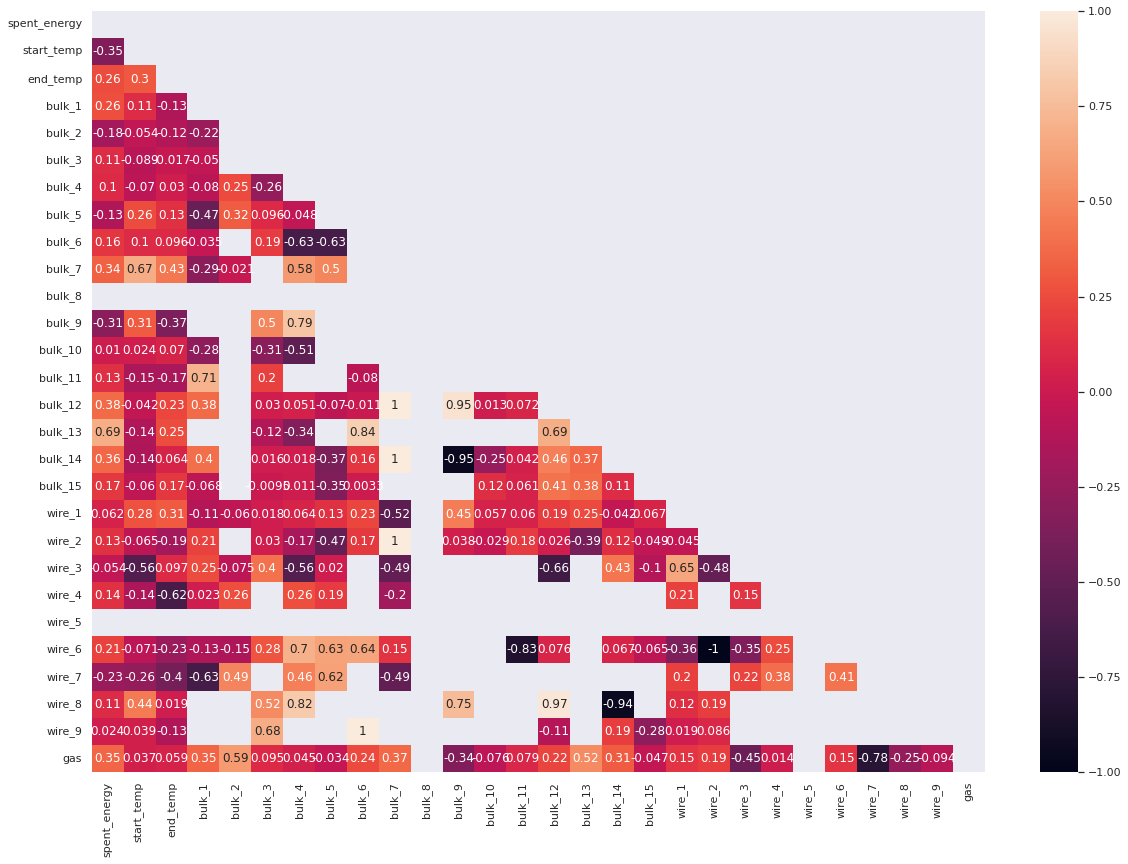

In [74]:
sns.set(rc={'figure.figsize':(20,14)})
sns.heatmap(
    df_full.corr(),
    annot=True,
    mask=np.triu(np.ones_like(df_full.corr()))
)
plt.show()

Теперь взглянем на $\phi_K$:

In [75]:
phik_overview = df_full.phik_matrix()

interval columns not set, guessing: ['spent_energy', 'start_temp', 'end_temp', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'gas']


Not enough unique value for variable bulk_8 for analysis 1. Dropping this column
Not enough unique value for variable wire_5 for analysis 0. Dropping this column


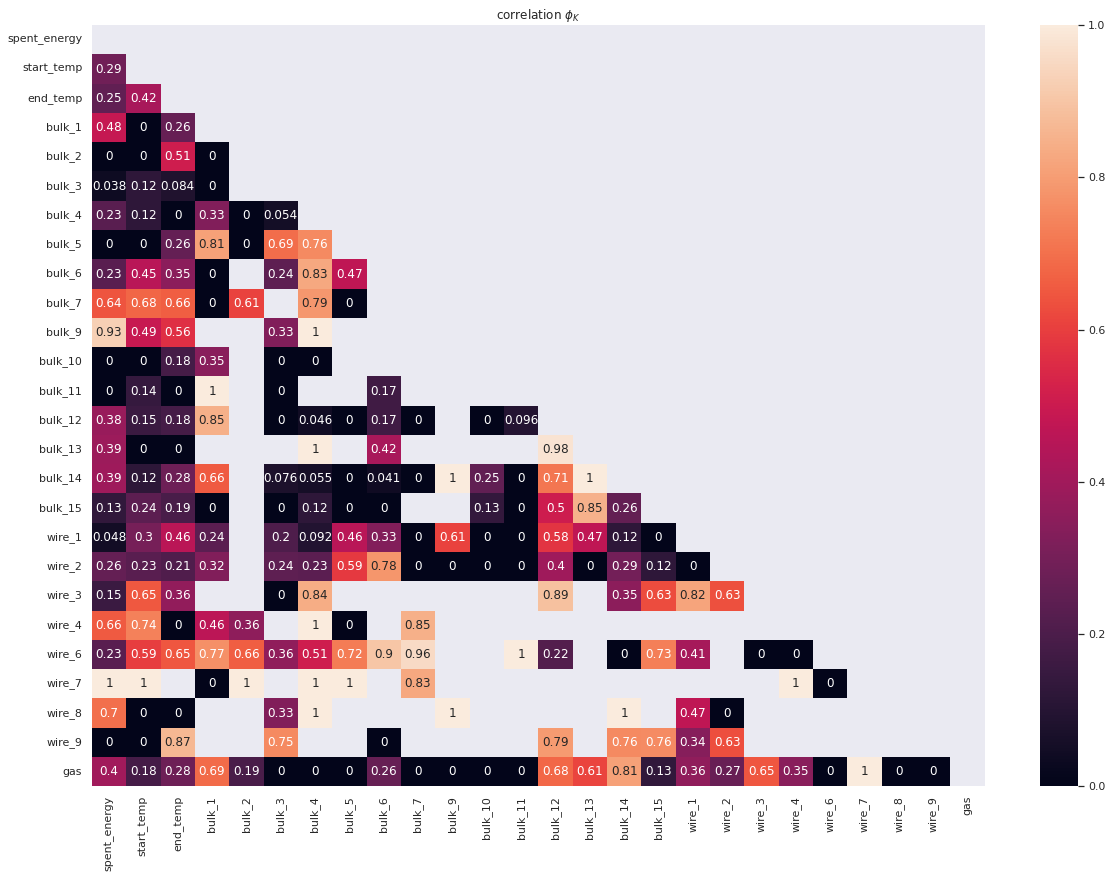

In [76]:
sns.heatmap(
    phik_overview,
    annot=True,
    mask=np.triu(np.ones_like(phik_overview))
)
plt.title(r'correlation $\phi_K$')
plt.show()

Изучив тепловые карты, можно прийти к выводу, что **в данных присутствует проблема мультиколлинеарности**. Если значительные сильные корреляции (>0.8) между различными сыпучими материалами и различными проволоками. 

Что приводит нас к следующему: 
- при моделировании обязательно применять стандартизацию;
- у линейных моделей (линейной регресии) обязательно использовать регуляризацию, предпочтительно L2.

Иначе мультиколлинеарность может существенно испортить интерпретируемость наших линейных моделей.

Сравнивая корреляции Пирсона и $\phi_K$ и их значения для целевого признака, можно заметить существенные различия.

Если линейная корреляция на конечную температуру не превышает 0.62 по модулю, и признаков, существенно влияющих на целевой признак не очень много; то для нелинейной корреляции, максимальное значение - 0.87, а существенно влияющих признаков гораздо больше.

### Анализ редких признаков

Нам необходимо оценить заполненность наших признаков, чтобы понять, какие именно признаки редко используются.

In [77]:
percent_non_missing = df_full.notnull().sum() * 100 / len(df_full)
non_missing_df = pd.DataFrame({'column_name':df_full.columns, 'percent_non_missing':percent_non_missing})

In [78]:
non_missing_df = non_missing_df.sort_values(by='percent_non_missing', ascending=False)

Поставим отсечку в 5% заполненности данных:

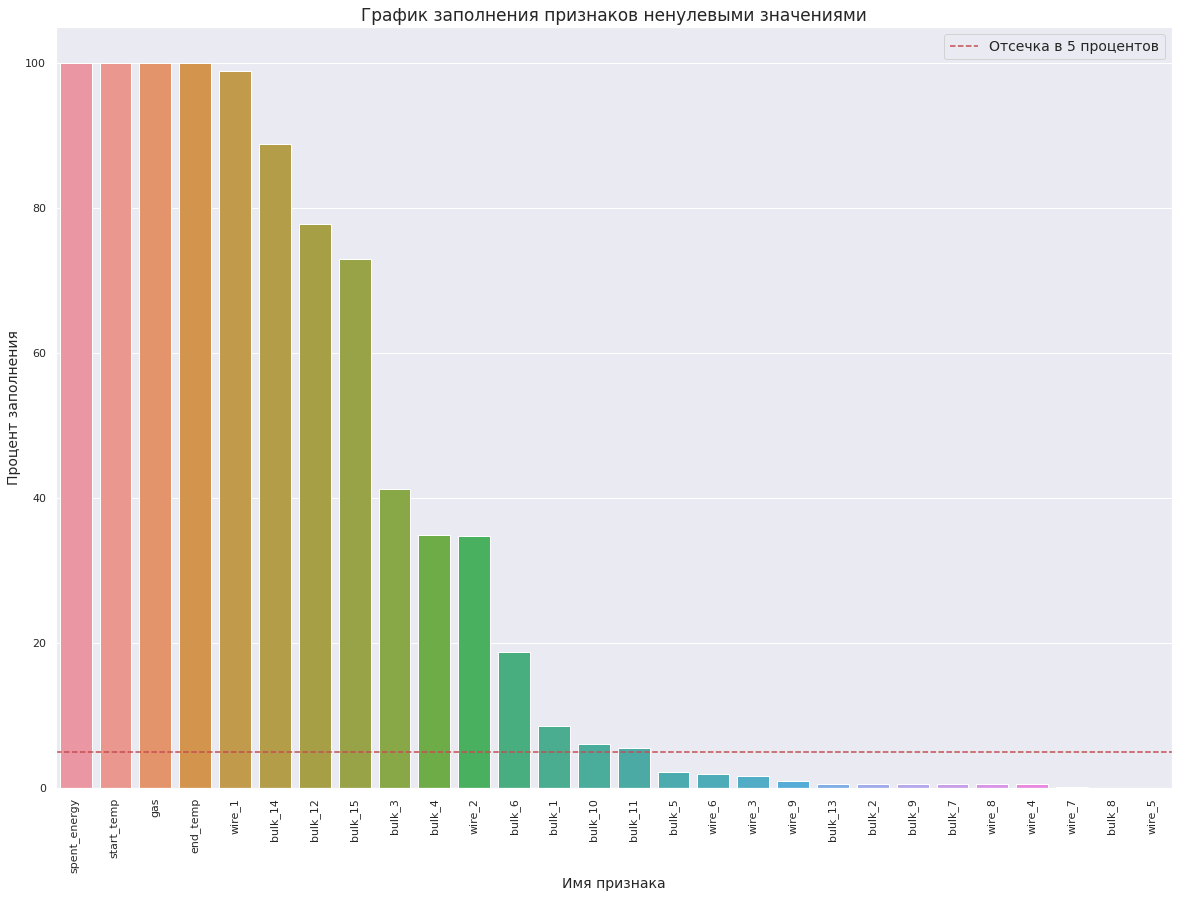

In [79]:
graph = sns.barplot(x='column_name', y='percent_non_missing', data=non_missing_df)
graph.axhline(y=5, linestyle='--', color='r', label='Отсечка в 5 процентов')
plt.xticks(rotation=90)
plt.xlabel('Имя признака', fontsize=14)
plt.ylabel('Процент заполнения', fontsize=14)
plt.title('График заполнения признаков ненулевыми значениями', fontsize=17)
plt.legend(fontsize='14')
plt.show()

Как мы видим, у нас около половины признаков не превышают отсечку в 5% заполненности данных. Значений у этих признаков слишком мало, чтобы эффективно обучить модели, поэтому удалим их.

In [80]:
features_to_drop = non_missing_df[non_missing_df['percent_non_missing'] < 5]['column_name'].tolist()

In [81]:
df_full = df_full.drop(columns=features_to_drop)

---
**Вывод:** завершив этап предобработки данных, мы
- соединили таблицы в единый датасет, моделирующий ковш, в котором легируется сталь, при этом:
    - создали дополнительный признак затраченной энергии "energy_spent", найдя полную мощность (из активной и реактивной) и умножив её на время накаливания дуги; при этом мы агрегировали затраченную энергию по партиям стали;
    - создали признак начальной температуры "start_temp"; мы сгруппировали значения начальной и конечной температуры по партиям стали;
- устранили аномалии в датасете (затраченная энергия >5000, температура <1350) и приняли решение не обрабатывать оставшиеся экстремальные значения признаков;
- провели поиск дубликатов - их не обнаружено;
- удалили лишние признаки, носящие неинформативный характер для построения моделей;
- проверили полный датасет на мультиколлинеарность - **проблема мультиколлинеарности есть** и приняли решение в обязательном порядке стандартизировать данные и у линейных моделей использовать регуляризацию L2;
- проанализировали наш полный датасет на предмет заполненности признаков и обнаружили, что около половины признаков не проходят отсечку в 5% заполненности данных; мы удалили эти признаки из датасета, т.к. их значений слишком мало, чтобы эффективно обучить модели.

## Обучение моделей

### Разбиение данных на выборки

Разобьем наши данные на обучающую и тестовую выборку. Обучающая включает в себя и валидационную, мы будем использовать кросс-валидацию. Соотношение обучающей и тестовой - 75:25.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(['end_temp'], axis=1), # признаки
    df_full['end_temp'], # таргет
    test_size=0.25,
    random_state=random_state,
)

X_train.shape, X_test.shape

((1743, 14), (581, 14))

### Подготовка preprocessing-шага для pipeline'ов

Подготовим препроцессинг-шаг для наших пайплайнов. Он будет включать в себя:
- заполнение NaN-значений нулями;
- стандартизацию всех числовых признаков.

In [83]:
preprocessor = Pipeline([

    # ===== Заполнение пропусков нулями =====
    ('missing_imputation', SimpleImputer(strategy='constant', fill_value=0)),
    
    # == Стандартизация признаков ====
    ('standard_scaler', StandardScaler())
])

### Построение моделей

Мы построим три модели:
- линейную регрессию с L2 регуляризацией;
- случайный лес;
- градиентный бустинг CatBoost.

Для каждой модели мы будем использовать пайплайн и кросс-валидацию на 8 фолдах.

Мы будем считать метрику МАЕ.

In [84]:
# Для сводной таблицы
model = []
mae_score = []

#### Ridge-регрессия

In [85]:
%%time

lr_pipe = Pipeline(steps=[ # Строим пайплайн с препроцессором
        ('preprocessor', preprocessor),
        ('model', Ridge(alpha=5, solver='lsqr', random_state=random_state))
])

lr_pipe.fit(X_train, y_train) # Обучаем модель

# Получаем МАЕ на кросс-валидации обучающего набора данных
lr_best_mae = cross_val_score(lr_pipe, X_train, y_train, scoring="neg_mean_absolute_error", cv=8)

CPU times: user 94.2 ms, sys: 111 µs, total: 94.3 ms
Wall time: 93.3 ms


In [86]:
model.append('Ridge regression')
mae_score.append(-lr_best_mae.mean())

print(f'Лучшая модель ridge-регресии показала MAE: {-lr_best_mae.mean()}.')
print(f'Гиперпараметры:')
lr_pipe

Лучшая модель ridge-регресии показала MAE: 6.668417731819348.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('missing_imputation',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('standard_scaler', StandardScaler())])),
                ('model', Ridge(alpha=5, random_state=190623, solver='lsqr'))])

#### Случайный лес

In [87]:
%%time

rfr_pipe = Pipeline(steps=[ # Строим пайплайн с препроцессором
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor())
])

parameter_space = { # Задаём пространство гиперпараметров для поиска по решётке
    'model__n_estimators' : [100, 300, 500], 
    'model__max_depth'     : [7, 10, 14],
    'model__random_state' : [random_state]
}

# Инициализируем поиск по решётке с 8 фолдами и скорингом МАЕ
rfr_grid = GridSearchCV(rfr_pipe, parameter_space, scoring='neg_mean_absolute_error', cv=8, n_jobs=n_jobs)

rfr_grid.fit(X_train, y_train) # Обучаем модель

rfr_best = rfr_grid.best_estimator_ # Сохраняем лучшую модель для визуализации гиперпараметров
rfr_best_mae = rfr_grid.best_score_ # Сохраняем лучшие показатели метрики МАЕ

CPU times: user 2.35 s, sys: 24.4 ms, total: 2.37 s
Wall time: 32.2 s


In [88]:
model.append('Random Forest Regressor')
mae_score.append(-rfr_best_mae)

print(f'Лучшая модель случайного леса показала MAE: {-rfr_best_mae}.')
print(f'Гиперпараметры:')
rfr_best

Лучшая модель случайного леса показала MAE: 6.560485143725694.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('missing_imputation',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('standard_scaler', StandardScaler())])),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=300,
                                       random_state=190623))])

#### Градиентный бустинг

In [89]:
%%time

cbr_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor())
])

parameter_space = {
    'model__num_trees' : [100, 200], 
    'model__depth'     : [3, 6],
    'model__learning_rate' : [0.03, 0.1],
    'model__random_state' : [random_state],
    'model__silent' : [True]
}

cbr_grid = GridSearchCV(cbr_pipe, parameter_space, scoring='neg_mean_absolute_error', cv=8, n_jobs=n_jobs)

cbr_grid.fit(X_train, y_train)

cbr_best = cbr_grid.best_estimator_
cbr_best_mae = cbr_grid.best_score_

CPU times: user 1.68 s, sys: 536 ms, total: 2.22 s
Wall time: 32.1 s


In [90]:
model.append('CatBoost Regressor')
mae_score.append(-cbr_best_mae)

print(f'Лучшая модель градиентного бустинга показала MAE: {-cbr_best_mae}.')
print(f'Гиперпараметры:')
cbr_results = pd.DataFrame(cbr_grid.cv_results_)
cbr_results[cbr_results['rank_test_score'] == 1]['params'].to_dict()

Лучшая модель градиентного бустинга показала MAE: 6.4815230231217456.
Гиперпараметры:


{6: {'model__depth': 6,
  'model__learning_rate': 0.1,
  'model__num_trees': 100,
  'model__random_state': 190623,
  'model__silent': True}}

---
**Вывод:** завершив этап обучения моделей, мы
- разбили данные на обучающую и тестовую выборку в соотношении 75:25;
- подготовили препроцессинг-шаг для пайплайнов, включающий в себя
    - заполнение nan-значений нулями;
    - стандартизацию числовых признаков;
- приняли решение использовать кросс-валидацию в 8 фолдов;
- в качестве метрики использовать МАЕ;
- построили три модели - ridge-регресиию, случайный лес и градиентный бустинг CatBoost и собрали статистику по показателям метрик для этих моделей.

## Анализ моделей

### Выбор лучшей модели

Посмотрим на результаты наших моделей, выберем лучшую.

In [91]:
models_dict = {'model' : model, 'mae_score' : mae_score}
models_results = pd.DataFrame(models_dict)
models_results

,model,mae_score
0,Ridge regression,6.668418
1,Random Forest Regressor,6.560485
2,CatBoost Regressor,6.481523


Лучше всех показал себя градиентный бустинг - **6.48 МАЕ**; выбираем его!

### Расчёт MAE на тестовом наборе данных

Пришло время протестировать нашу лучшую модель.

In [92]:
predictions = cbr_grid.predict(X_test)

In [93]:
mean_absolute_error(y_test, predictions)

6.449836023472739

Итого, наша модель градиентного бустинга показала хороший результат в **6.45 МАЕ**.

### Анализ ошибки

Построим графики рассеяния, чтобы оценить точность наших моделей и величины ошибок между предсказаниями и целевыми признаками; это поможет нам понять, за счёт чего у нас образуется такая ошибка.

In [94]:
dict_target_predictions = {
    'target' : y_test,
    'predictions' : predictions,
    'error' : y_test - predictions
}

df_target_predictions = pd.DataFrame(dict_target_predictions)

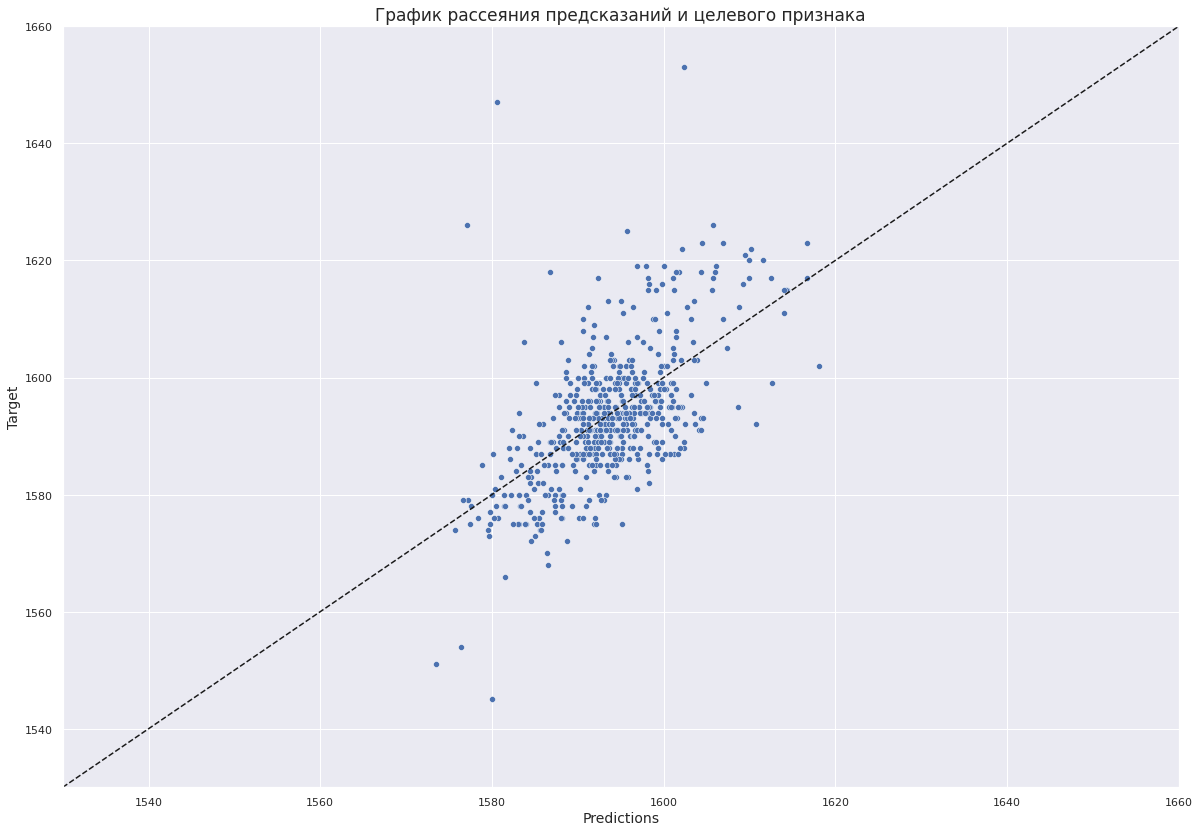

In [95]:
g = sns.scatterplot(data=df_target_predictions, x='predictions', y='target')

g.plot([1530, 1660], [1530, 1660], ls="--", c=".1")
g.set(xlim=(1530, 1660), ylim=(1530, 1660))

plt.title('График рассеяния предсказаний и целевого признака', fontsize=17)
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Target', fontsize=14)

plt.show()

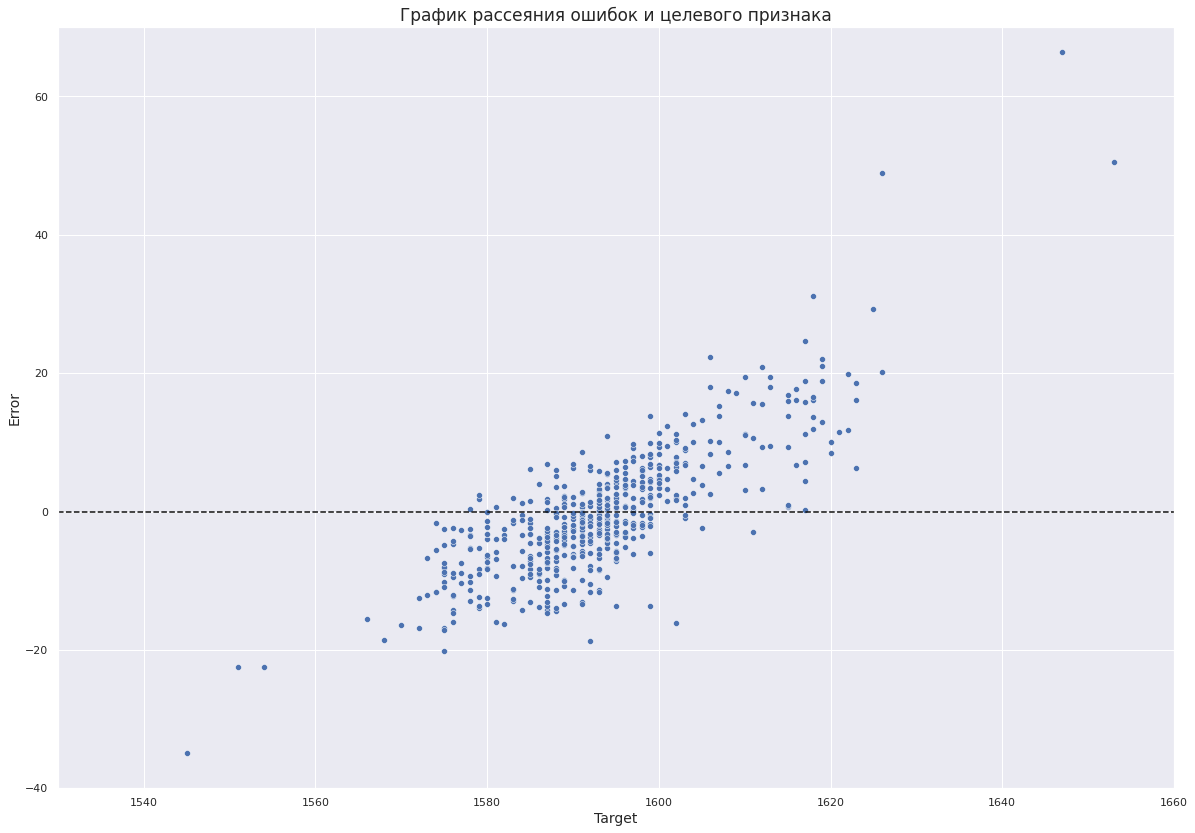

In [96]:
g = sns.scatterplot(data=df_target_predictions, x='target', y='error')

g.plot([1530, 1660], [0, 0], ls="--", c=".05")
g.set(xlim=(1530, 1660), ylim=(-40, 70))

plt.title('График рассеяния ошибок и целевого признака', fontsize=17)
plt.xlabel('Target', fontsize=14)
plt.ylabel('Error', fontsize=14)

plt.show()

Как мы видим, наша модель склонна ошибаться в очень низких и очень высоких температурах; высокие температуры склонна занижать, а низкие - завышать.

В целом, у нашей модели низкое смещение (bias), но высокий разброс (variance), что типично для градиентного бустинга.

### Анализ важности факторов

Давайте оценим важность факторов нашей модели, чтобы понимать какие показатели и как влияют на прогноз.

Посмотрим на пару предсказаний для примера:

In [97]:
shap.initjs()

explainer = shap.TreeExplainer(cbr_grid.best_estimator_.named_steps['model'])
shap_values = explainer.shap_values(cbr_grid.best_estimator_[:-1].transform(X_test))


shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [98]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[69,:], X_test.iloc[69,:])

Построим сводный график для всех предсказаний:

In [99]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

Визуализируем суммарный график влияния факторов:

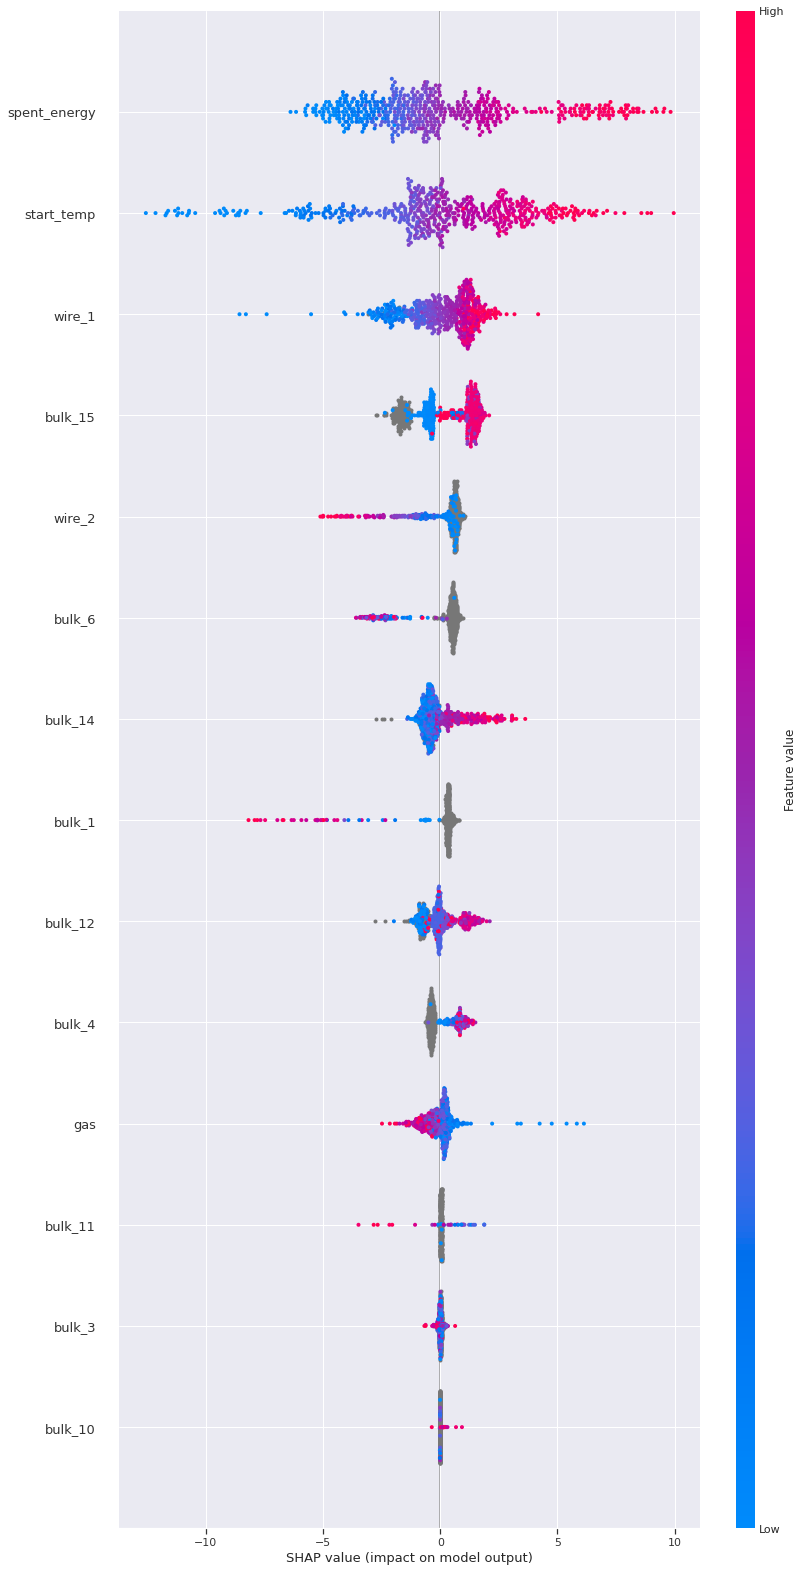

In [100]:
shap.summary_plot(shap_values, X_test, plot_size=[12,22])

Из данного графика можно почерпнуть следующие инсайты:
- чем выше значения этих признаков, тем выше конечная температура:
    - затраченная энергия;
    - начальная температура;
    - объём проволоки №1;
    - объём сыпучих материалов №4, №12, №14, №15;
- чем ниже значения этих признаков, тем выше конечная температура:
    - объём газа;
    - объём проволоки №2;
    - объём сыпучих материалов №1, №6;
- показатели этих признаков почти не влияют на конечную температуру:
    - объём сыпучих материалов №3, №10, №11.

### Проверка модели на адекватность

Проверим нашу модель на адекватность. Построим модель-пустышку, заполняющую предсказания медианой целевого признака обучающего набора данных.

In [101]:
%%time

dummy_pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', DummyRegressor(strategy='median'))
])

dummy_pipe.fit(X_train, y_train)

predictions_dummy = dummy_pipe.predict(X_test)

CPU times: user 9.3 ms, sys: 85 µs, total: 9.38 ms
Wall time: 7.92 ms


In [102]:
mean_absolute_error(y_test, predictions_dummy)

8.075731497418245

Модель-пустышка показала результат в **8.08 МАЕ**, что в 1.25 раз выше метрики нашей модели. Наша модель градиентного бустинга адекватна!

---
**Вывод:** завершив этап анализа моделей, мы
- выбрали лучшую модель; ею оказалась модель градиентного бустинга CatBoost с показателем МАЕ 6.48 для обучающего набора данных;
- протестировали нашу модель и получили значение **МАЕ 6.45 на тестовом наборе данных**;
- проанализировали точность нашей модели и величины ошибок между предсказаниями и целевыми признаками и выяснили, что наша модель склонна ошибаться в очень низких и очень высоких температурах; высокие температуры склонна занижать, а низкие - завышать; в целом, у нашей модели низкое смещение (bias), но высокий разброс (variance), что типично для градиентного бустинга;
- проанализировали важность факторов нашей модели и получили следующие инсайты:
    - чем выше значения этих признаков, тем выше конечная температура:
        - затраченная энергия;
        - начальная температура;
        - объём проволоки №1;
        - объём сыпучих материалов №4, №12, №14, №15;
    - чем ниже значения этих признаков, тем выше конечная температура:
        - объём газа;
        - объём проволоки №2;
        - объём сыпучих материалов №1, №6;
    - показатели этих признаков почти не влияют на конечную температуру:
        - объём сыпучих материалов №3, №10, №11;
- проверили нашу модель на адекватность: модель-пустышка показала результат в 8.08 МАЕ на тестовом наборе данных, что в 1.25 раз выше значения метрики нашей модели; наша модель адекватна.        

## Общий вывод

Сразу отвечая на главный вопрос проекта - для предсказания конечной температуры стали в процессе легирования мы предлагаем использовать обученную нами модель градиентного бустинга CatBoost, которая показывает результат в **6.45 МАЕ** на тестовом наборе данных. Модель имеет следующие гиперпараметры:

In [103]:
cbr_results[cbr_results['rank_test_score'] == 1]['params'].to_dict()

{6: {'model__depth': 6,
  'model__learning_rate': 0.1,
  'model__num_trees': 100,
  'model__random_state': 190623,
  'model__silent': True}}

В целом, в ходе проекта:

- завершив этап подготовки данных, мы обнаружили, что
    - данные в датасете df_arc представляют собой итерации прогревов металла графитовыми электродами; каждая строка - итерация прогрева;
        - пропусков в df_arc нет;
        - присутствует аномалия - "Реактивная мощность" со значением -715.48;
    - данные в датасетах df_bulk и df_wire представляют собой строки, в которых собрана сразу вся информация по всем итерациям - в разных признаках, а датасеты \*\_time - временные метки для каждой итерации добавления сыпучих материалов/проволоки;
        - данные разрежены в данных датасетах; есть признаки с высокой плотностью значений, а остальные - по большей части пустые; это соответствует тому, что при легировании каждой новой партии, было осуществлено всего 2-3 итерации добавления сыпучих материалов/проволоки и только в редких случаях - больше 4-5; 
    - данные в датасете df_gas представляют собой одиночные строки добавления газа в партии металла; неитеративные;
        - строк в датасете практически столько же, сколько всего партий - 3239 строк на 3241 партии;
    - данные в датасете df_temp представляют собой итерации замеров температуры после процесса легирования стали - включая замер температуры до начала процесса;
        - в данных присутствуют пропуски - около 19% строк с пропусками значений температуры;
        - у температуры большая часть распределения находится в диапазоне 1500-1700 градусов; есть значения с температурой около 1200 градусов, судя по всему, выброс;

    - судя по временным меткам, итеративный процесс легирования стали можно выразить в виде цепочки:(если это 1ая итерация — замер температуры -> ) старт нагрева электродов -> финиш нагрева электродов -> добавление проволоки/сыпучих материалов → добавление газа -> замер температуры ( -> новая итерация);
    
    
- завершив этап предобработки данных, мы
    - соединили таблицы в единый датасет, моделирующий ковш, в котором легируется сталь, при этом:
        - создали дополнительный признак затраченной энергии "energy_spent", найдя полную мощность (из активной и реактивной) и умножив её на время накаливания дуги; при этом мы агрегировали затраченную энергию по партиям стали;
        - создали признак начальной температуры "start_temp"; мы сгруппировали значения начальной и конечной температуры по партиям стали;
    - устранили аномалии в датасете (затраченная энергия >5000, температура <1350) и приняли решение не обрабатывать оставшиеся экстремальные значения признаков;
    - провели поиск дубликатов - их не обнаружено;
    - удалили лишние признаки, носящие неинформативный характер для построения моделей;
    - проверили полный датасет на мультиколлинеарность - **проблема мультиколлинеарности есть** и приняли решение в обязательном порядке стандартизировать данные и у линейных моделей использовать регуляризацию L2;
    - проанализировали наш полный датасет на предмет заполненности признаков и обнаружили, что около половины признаков не проходят отсечку в 5% заполненности данных; мы удалили эти признаки из датасета, т.к. их значений слишком мало, чтобы эффективно обучить модели;
    
    
- завершив этап обучения моделей, мы
    - разбили данные на обучающую и тестовую выборку в соотношении 75:25;
    - подготовили препроцессинг-шаг для пайплайнов, включающий в себя
        - заполнение nan-значений нулями;
        - стандартизацию числовых признаков;
    - приняли решение использовать кросс-валидацию в 8 фолдов;
    - в качестве метрики использовать МАЕ;
    - построили три модели - ridge-регресиию, случайный лес и градиентный бустинг CatBoost и собрали статистику по показателям метрик для этих моделей;    


- завершив этап анализа моделей, мы
    - выбрали лучшую модель; ею оказалась модель градиентного бустинга CatBoost с показателем МАЕ 6.48 для обучающего набора данных;
    - протестировали нашу модель и получили значение **МАЕ 6.45 на тестовом наборе данных**;
    - проанализировали точность нашей модели и величины ошибок между предсказаниями и целевыми признаками и выяснили, что наша модель склонна ошибаться в очень низких и очень высоких температурах; высокие температуры склонна занижать, а низкие - завышать; в целом, у нашей модели низкое смещение (bias), но высокий разброс (variance), что типично для градиентного бустинга;
    - проанализировали важность факторов нашей модели и получили следующие инсайты:
        - чем выше значения этих признаков, тем выше конечная температура:
            - затраченная энергия;
            - начальная температура;
            - объём проволоки №1;
            - объём сыпучих материалов №4, №12, №14, №15;
        - чем ниже значения этих признаков, тем выше конечная температура:
            - объём газа;
            - объём проволоки №2;
            - объём сыпучих материалов №1, №6;
        - показатели этих признаков почти не влияют на конечную температуру:
            - объём сыпучих материалов №3, №10, №11;
    - проверили нашу модель на адекватность: модель-пустышка показала результат в 8.08 МАЕ на тестовом наборе данных, что в 1.25 раз выше значения метрики нашей модели; наша модель адекватна.        

In [104]:
cbr_grid.best_estimator_.named_steps['model'].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 190623,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.10000000149011612,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iteration